# Estimating the models' parameters
**Note**: This notebook should be run after ```sample_synth_pop.ipynb``` and ```prepare_data.ipynb```.

The objective of this notebook is to estimate the values of the Agent-Based Model parameters that reproduce or fit (in a sense that will be defined later) the reality of the epidemic in Switzerland.

# Imports and paths

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
%cd ..

/home/clement/epfl/mobility_behavior_abm


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
from scipy.optimize import minimize_scalar, minimize, shgo
from tqdm.notebook import tqdm
from abm.model import ABM
from abm.parallel import ParallelABM
from abm.contacts import load_period_activities
sns.set_theme()
# Creates an RNG with fixed seed for reproducibility
rng = np.random.default_rng(seed=42)
def normalize(array):
    return (np.array(array) - np.mean(array)) / np.std(array)

# Target data: the COVID-19 incidence in Switzerland
**Note**: For the moment, the model is restricted to the canton of Vaud.

## Loading the daily confirmed cases
We'll load a dataset that was built in ```sample_synth_pop.ipynb``` and ```prepare_data.ipynb``` and gives the daily confirmed cases in the studied area. 

In [3]:
daily_cases = pd.read_csv('data/abm/vaud/prepared/vaud_daily_cases.csv.gz', parse_dates=['date'], index_col='date')
daily_cases.head()

daily confirmed cases
date                             
2020-02-26                      1
2020-02-27                      0
2020-02-28                      0
2020-03-02                      5
2020-03-03                      4

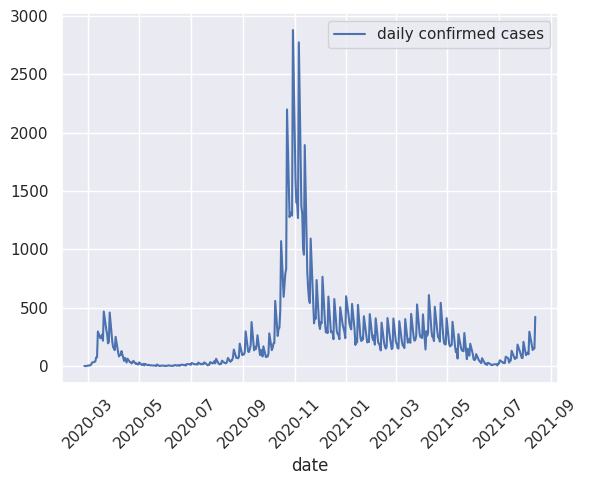

In [4]:
sns.lineplot(daily_cases)
plt.xticks(rotation=45)
plt.show()

## Loading the public test data
We'll also load the dataset that gives the total number of tests and the share of positive tests, by age class:

In [5]:
test_data = pd.read_csv('data/abm/vaud/prepared/vaud_daily_tests_data.csv', parse_dates=['date'])
test_data = test_data.set_index('date')
test_data.head()

age_class     entries  entries_pos  entries_neg  pos_share
date                                                                 
2020-06-01     0 - 9  494.000000          1.0   493.000000   0.002024
2020-06-02     0 - 9  538.571429          1.0   537.571429   0.001912
2020-06-03     0 - 9  583.142857          1.0   582.142857   0.001800
2020-06-04     0 - 9  627.714286          1.0   626.714286   0.001688
2020-06-05     0 - 9  672.285714          1.0   671.285714   0.001577

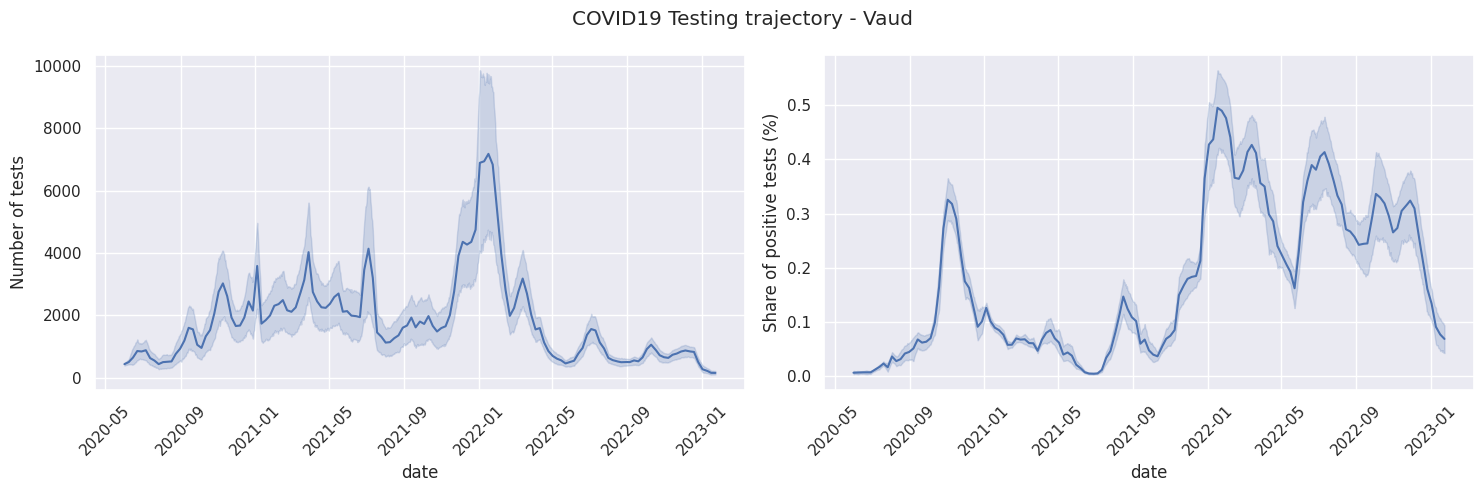

In [6]:
plt.figure(figsize=(15, 5), tight_layout=True)
plt.suptitle('COVID19 Testing trajectory - Vaud')
plt.subplot(121)
sns.lineplot(data=test_data, x='date', y='entries')
plt.ylabel('Number of tests')
plt.xticks(rotation=45)

plt.subplot(122)
sns.lineplot(data=test_data, x='date', y='pos_share')
plt.ylabel('Share of positive tests (%)')
plt.xticks(rotation=45)
plt.show()

## Selecting a time period
We'll also need to choose a time period, i.e. an epidemic wave which we cant to focus on. For now we'll choose the second epidemic wave: according to [The Ordinances relative to COVID-19 in Switzerland](https://www.bag.admin.ch/bag/en/home/krankheiten/ausbrueche-epidemien-pandemien/aktuelle-ausbrueche-epidemien/novel-cov/massnahmen-des-bundes.html#757183649), the restrictions due to the first epidemic wave were lifted on the 27th of April 2020. In October 2020 Switzerland experienced a rapid surge in cases (as seen on the previous figure), which led to strict restrictions, which were applied from the 28th of October on.  
Consequently, to first estimate the parameters **without restrictions**, we'll only consider the surging phase of the second wave: from 2020-08-08 to 2020-10-27 included.

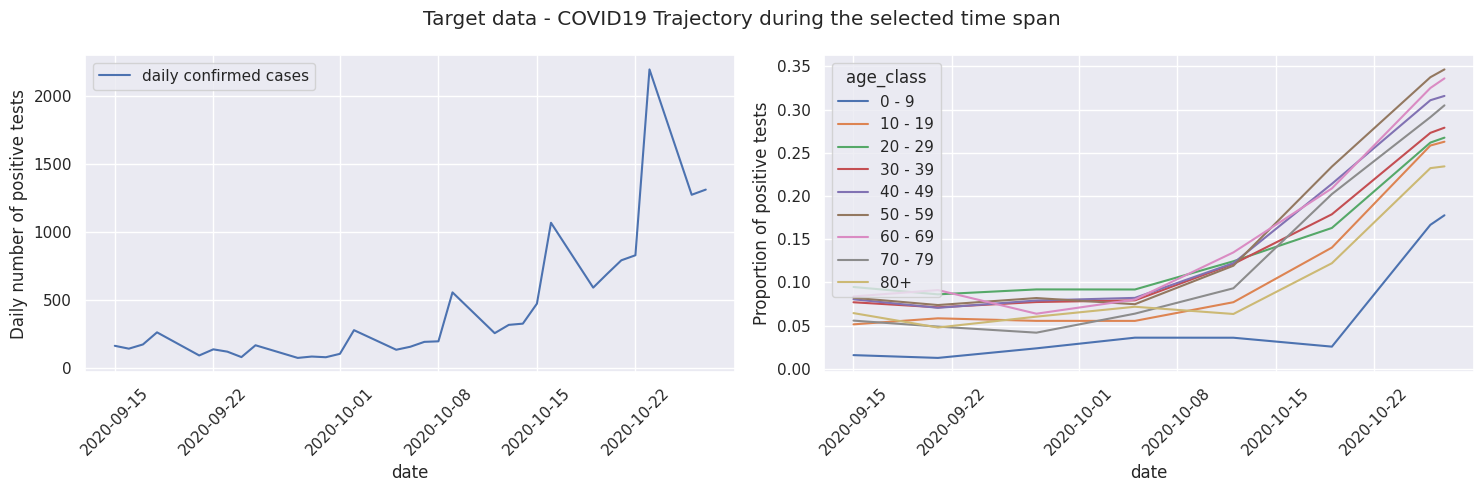

In [7]:
start_date, end_date = pd.to_datetime('2020-09-15'), pd.to_datetime('2020-10-27')
second_wave_cases = daily_cases[(daily_cases.index >= start_date) & (daily_cases.index <= end_date)].copy()
second_wave_tests = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)].copy()

plt.figure(figsize=(15, 5), tight_layout=True)
plt.suptitle('Target data - COVID19 Trajectory during the selected time span')
plt.subplot(121)
sns.lineplot(second_wave_cases)
plt.ylabel('Daily number of positive tests')
plt.xticks(rotation=45)

plt.subplot(122)
sns.lineplot(second_wave_tests, x='date', y='pos_share', hue='age_class')
plt.ylabel('Proportion of positive tests')
plt.xticks(rotation=45)
plt.savefig('figures/abm/covid_data/targets.png')
plt.show()

It's clear that not all weekdays are responsible for the same number of cases. However the synthetic population cannot take those variations into account, since it considers the same activities for all simulation days.  
Thus, we'll use the **7-days windowed average** to smooth the curve:

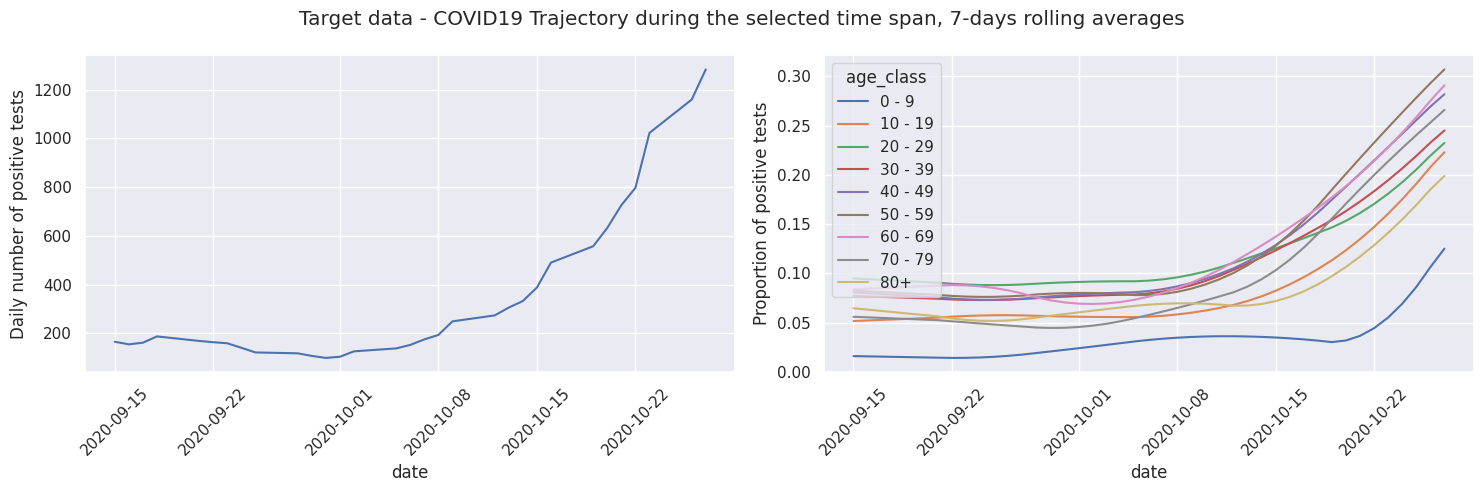

In [8]:
target_cases = second_wave_cases['daily confirmed cases'].rolling('7D').mean()
target_tests = second_wave_tests.groupby('age_class').rolling('7D').mean()

plt.figure(figsize=(15, 5), tight_layout=True)
plt.suptitle('Target data - COVID19 Trajectory during the selected time span, 7-days rolling averages')
plt.subplot(121)
sns.lineplot(target_cases)
plt.ylabel('Daily number of positive tests')
plt.xticks(rotation=45)

plt.subplot(122)
sns.lineplot(target_tests, x='date', y='pos_share', hue='age_class')
plt.ylabel('Proportion of positive tests')
plt.xticks(rotation=45)
plt.show()

# Running an example

The first step is to define the model's parameters (i.e., the values that will be tested).

In [9]:
base_params = {
    'recovery_mean_time': 8.0,
    'recovery_std_time': 2.0,
    'soceco_attributes': ['age'],
    'soceco_params': np.array([0]),
    'inf_fraction_param': 0.005,
    'test_attributes': ['age'],
    'test_params': np.array([0]),
    'base_test_proba': 0.01,
    'inf_test_proba': 0.3,
    'apply_activity_reduction': False
}

We then need to load the activity data (visit matrices and agent locations). Those are loaded outside the model so that they can be shared between several ABM objects running in parallel.

In [10]:
activity_data = load_period_activities()

Creating activity matrices...
Processing period 0
Processing period 1
Processing period 2
Processing period 3
Processing period 4
Processing period 5
Processing period 6
Processing period 7
Processing period 8
Processing period 9
Processing period 10
Processing period 11
Processing period 12
Processing period 13
Processing period 14
Processing period 15
Processing period 16
Processing period 17
Processing period 18
Processing period 19
Processing period 20
Processing period 21
Processing period 22
Processing period 23


We can now create an ABM object:

In [11]:
parallel_abm = ParallelABM(base_params, activity_data, n_models=2)

Loading the population dataset in the master..
Done
Computing population characteristics in the master...
Done
Assembling models 
Done


Finally, we need to define the duration of the simulation, as well as the initial infections.

We'll **force the initial days of the simulation**: this means that the number of new infections for the first few days will be fixed (taken from the real data). This allows us to better approximate the initial state of the actual simulation, rather than just taking the new infections on the first day.  
We'll set the new infections for a full week before the actual start of the simulation:

In [12]:
# Number of forced simulation days
forced_days = 14
simulation_days = second_wave_cases.shape[0] - forced_days
print(f"Forced days: {forced_days}, Duration set for {simulation_days} days")

Forced days: 14, Duration set for 17 days


In [13]:
# We need to indicate the number of daily cases for the forced phase
forced_daily_infections = target_cases.values[:forced_days]
forced_daily_infections

array([165.        , 154.5       , 161.33333333, 187.        ,
       168.4       , 163.2       , 158.8       , 140.2       ,
       121.2       , 117.6       , 107.        ,  98.8       ,
       103.6       , 125.8       ])

In [14]:
parallel_abm.force_simulation_start(forced_daily_infections)

We can now run the ABM:

In [15]:
model_daily_new_cases = parallel_abm.run_simulations(simulation_days)

Starting 2 parallel simulations
Simulation ended
Simulation ended
Simulations ended


# Visualization function
Let's present the results:

In [16]:
def show_model_output(parallel_abm, title, save_img_to=None):
    """
    Displays a comparison between reality and the model's output.
    -parallel_abm: ParallelABM object already run;
    -title: str, figure suptitle.
    -save_img_to: str, optional. Image file to which the figure should be saved.
    """
    # Retrieves the daily positive tests across all parallel simulations
    results = parallel_abm.get_results_dataframe(timestep='daily')
    fig = make_subplots(rows=2, cols=1,
                       subplot_titles=('Daily total number of positive tests',
                                       'Daily share of positive tests'))
    weeks = second_wave_cases.index
    
    # Choose the color palette here
    simulation_curve_colors = px.colors.qualitative.Plotly
    real_curve_color = 'slateblue'
    real_avg_color = 'lightseagreen'
    # == FIRST SUBPLOT: Number of positive tests ======== #
    for n_sim in range(parallel_abm.n_models):
        fig.add_trace(go.Scatter(x=weeks, y=results.query(f'simulation == {n_sim}')['positive tests'], mode='lines',
                                 name=f'simulation {n_sim}', legendgroup=f'sim{n_sim}',
                                 line=dict(dash='dash',  color=simulation_curve_colors[n_sim])),
                      row=1, col=1)
    
    # Traces the real positive tests curve
    fig.add_trace(go.Scatter(x=weeks, y=second_wave_cases['daily confirmed cases'], mode='lines', name='Real',
                             legendgroup='real', line={'color': real_curve_color}),
                  row=1, col=1)
    fig.add_trace(go.Scatter(x=weeks, y=target_cases.values, mode='lines', name='Real, 7-days rolling avg',
                             legendgroup='real_rolling', line={'color': real_avg_color}),
                  row=1, col=1)
    fig.update_yaxes(title='Number of positive tests', row=1, col=1)
    
    # == SECOND SUBPLOT: Share of positive tests ======= #
    # Simulation curves
    for n_sim in range(parallel_abm.n_models):
        fig.add_trace(go.Scatter(x=weeks, y=results.query(f'simulation == {n_sim}')['pos share'], mode='lines',
                                 name=f'simulation {n_sim}', legendgroup=f'sim{n_sim}', showlegend=False,
                                 line=dict(dash='dash',  color=simulation_curve_colors[n_sim])),
                      row=2, col=1)
    
    # Real curves (raw and rolling average)
    fig.add_trace(go.Scatter(x=weeks, y=second_wave_tests['pos_share'], mode='lines', name='Real confirmed cases',
                  legendgroup='real', showlegend=False, line={'color': real_curve_color}),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=weeks, y=target_tests['pos_share'], mode='lines', name='Real, 7-days rolling avg',
                  legendgroup='real_rolling', showlegend=False, line={'color': real_avg_color}),
                  row=2, col=1)
    fig.update_yaxes(title='Proportion of positive tests, out of 1', row=2, col=1)
    fig.update_layout(title=title, height=800)
    
    # Save the image if required
    if save_img_to is not None:
        fig.write_image(save_img_to, width=1600, height=800)
    fig.show()

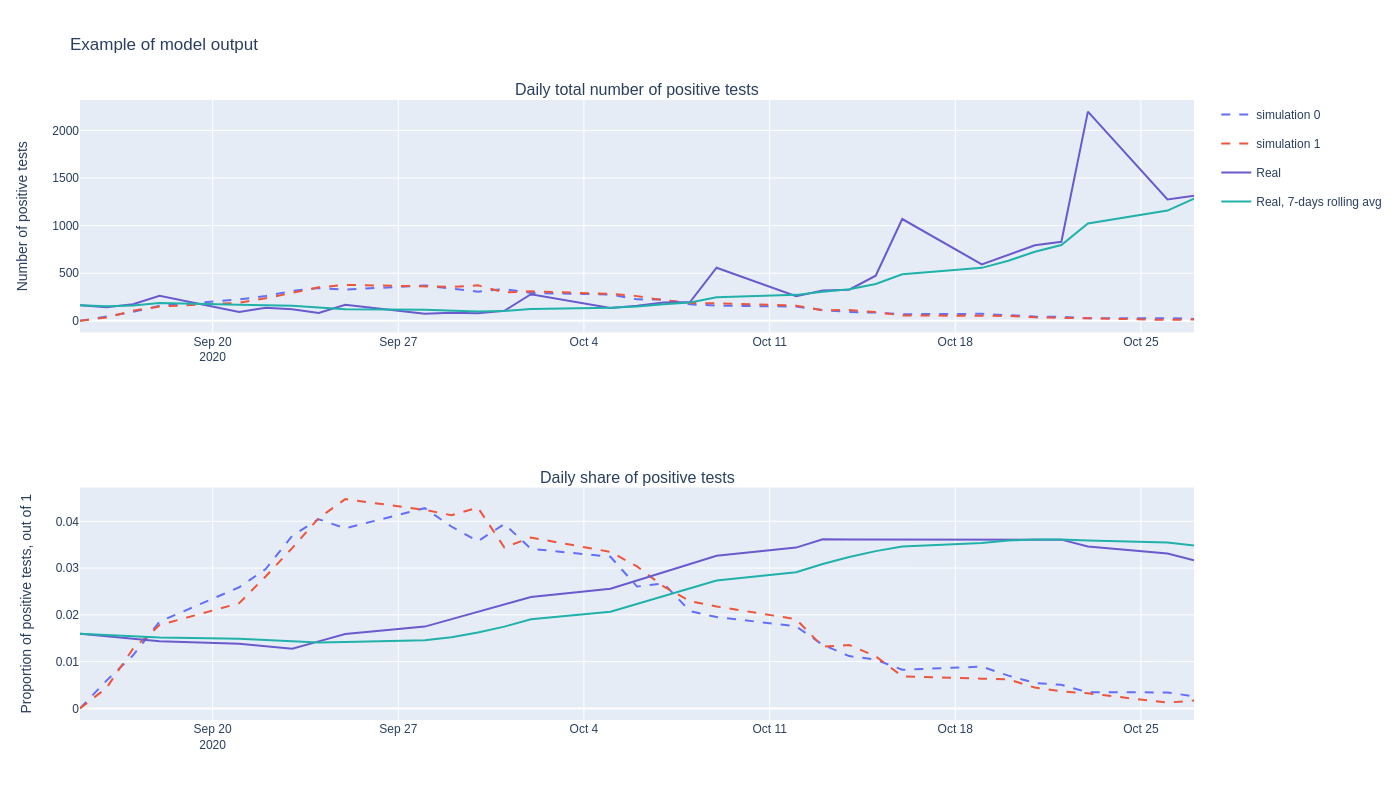

In [17]:
show_model_output(parallel_abm, "Example of model output")

# Single-param calibration
In this section, we'll try to calibrate the model by only adjusting the ```inf_fraction_param``` parameter, which links the probability of becoming infected with the proportion of infected contacts.  

In [18]:
base_params = {
    'recovery_mean_time': 8.0,
    'recovery_std_time': 2.0,
    'soceco_attributes': ['age'],
    'soceco_params': np.array([0]),
    'inf_fraction_param': 0.005,
    'test_attributes': ['age'],
    'test_params': np.array([0]),
    'base_test_proba': 0.01,
    'inf_test_proba': 0.2,
    'apply_activity_reduction': False
}
parallel_abm = ParallelABM(base_params, activity_data, n_models=4)

Loading the population dataset in the master..
Done
Computing population characteristics in the master...
Done
Assembling models 
Done


## Defining loss functions
We'll define several loss functions, which all compare the real vs. estimated curves of positive tests. The share of positive tests is **not** taken into account here, which may lead to a suboptimal calibration, or even a completely unrealistic share of positive tests.

In [19]:
def mse_loss(model_output):
    """
    Returns the Mean Squared Error between the model's output
    and the actual number of confirmed cases over the studied period.
    -- model_output: Array containing the number of daily confirmed cases
        according to the model. The number of weeks should correspond to that
        in the studied period.
    """
    # Normalization
    model_output = (model_output - np.mean(target_cases)) / np.std(target_cases)
    cases = normalize(target_cases)
    return ((model_output - np.ravel(cases)) ** 2).sum()

In [20]:
def mae_loss(model_output):
    """
    Returns the Mean Absolute Error between the model's output
    and the actual number of confirmed cases over the studied period.
    -- model_output: Array containing the number of daily confirmed cases
        according to the model. The number of weeks should correspond to that
        in the studied period.
    """
    # Normalization
    model_output = (model_output - np.mean(target_cases)) / np.std(target_cases)
    cases = normalize(target_cases)
    return np.abs(model_output - np.ravel(cases)).sum()

In [21]:
def max_loss(model_output):
    """
    Returns the Maximum gap between the model's output
    and the actual number of confirmed cases over the studied period.
    -- model_output: Array containing the number of daily confirmed cases
        according to the model. The number of weeks should correspond to that
        in the studied period.
    """
    return np.abs(model_output - np.ravel(target_cases.values)).max()

## Optimization
We'll use Scipy's ```minimize_scalar```, which internally uses Bent's method, to search for the minimum of the loss function.

In [22]:
def single_param_model_loss(base_inf_proba, loss='mse'):
    # Modifies the param in the ABM object and resets it
    parallel_abm.set_param('inf_fraction_param', base_inf_proba)
    parallel_abm.force_simulation_start(forced_daily_infections)
    # Relaunches a simulation with the new param
    parallel_abm.run_simulations(simulation_days)
    # Retrieves the daily positive tests across all parallel simulations
    results = parallel_abm.get_results_dataframe(timestep='daily')
    # Computes the mean positive tests for every week
    model_mean = np.array(results.groupby('day')['positive tests'].mean())
    # Computes the loss
    if loss == 'mae':
        return mae_loss(model_mean)
    elif loss == 'mse':
        return mse_loss(model_mean)
    elif loss == 'max':
        return max((max_loss(results.query(f'simulation == {s}')['positive tests'])
                                     for s in range(parallel_abm.n_models)))
    else:
        raise ValueError(f'Loss {loss} not understood')

### With MAE

In [23]:
single_param_opt = minimize_scalar(single_param_model_loss, bounds=[0, 1], method='bounded', args=('mae'))

Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulat

In [24]:
single_param_opt

     fun: 8.78658335607686
 message: 'Solution found.'
    nfev: 21
     nit: 21
  status: 0
 success: True
       x: 0.0212862362522082

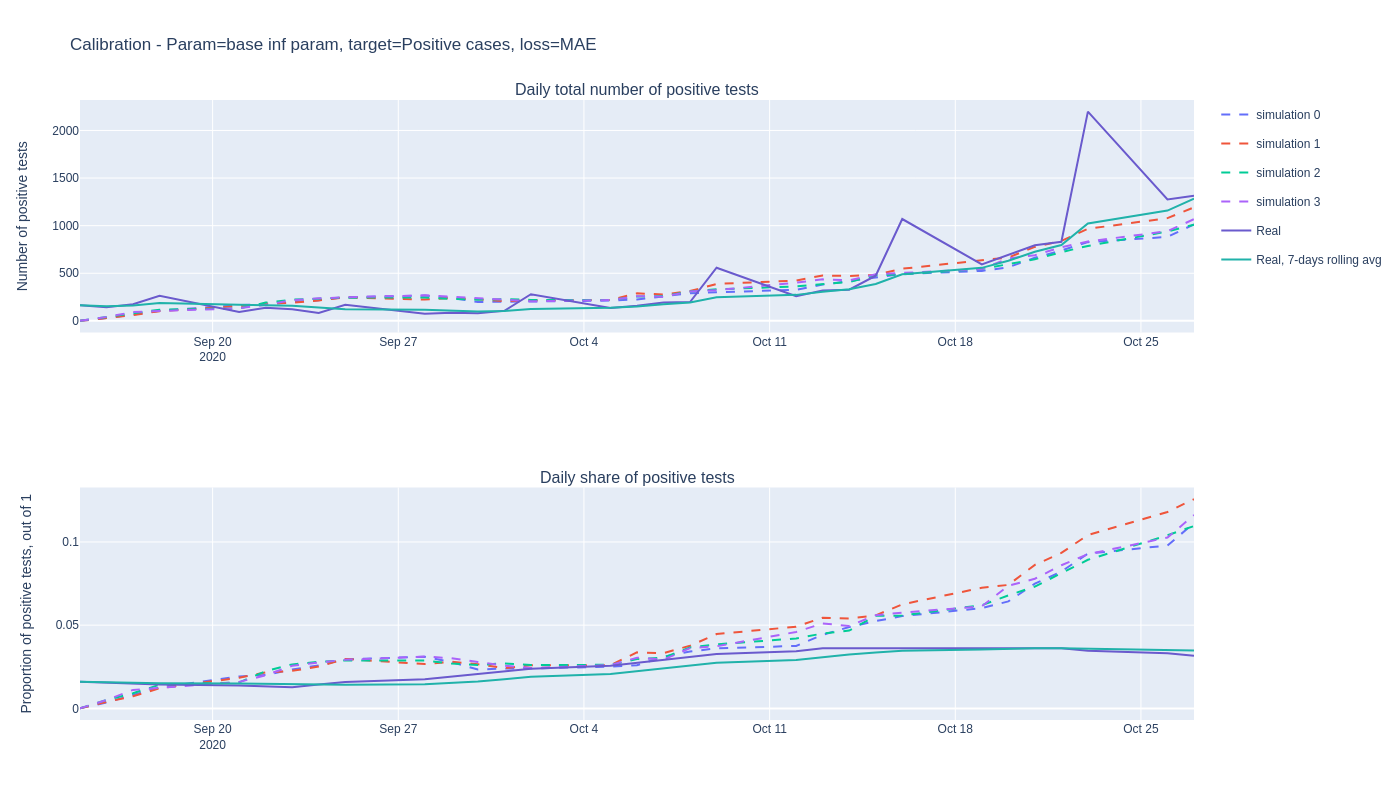

In [25]:
show_model_output(parallel_abm,
                  "Calibration - Param=base inf param, target=Positive cases, loss=MAE",
                  "figures/abm/calibration/one_param/inf_para_target=pt_loss=mae.png")

### With MSE

In [23]:
single_param_opt = minimize_scalar(single_param_model_loss, bounds=[0, 1], method='bounded', args=('mse'))

Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulation ended
Simulation ended
Simulation ended
Simulations ended
Starting 4 parallel simulations
Simulation ended
Simulat

In [24]:
single_param_opt

     fun: 2.9022344042750188
 message: 'Solution found.'
    nfev: 25
     nit: 25
  status: 0
 success: True
       x: 0.021826573165423028

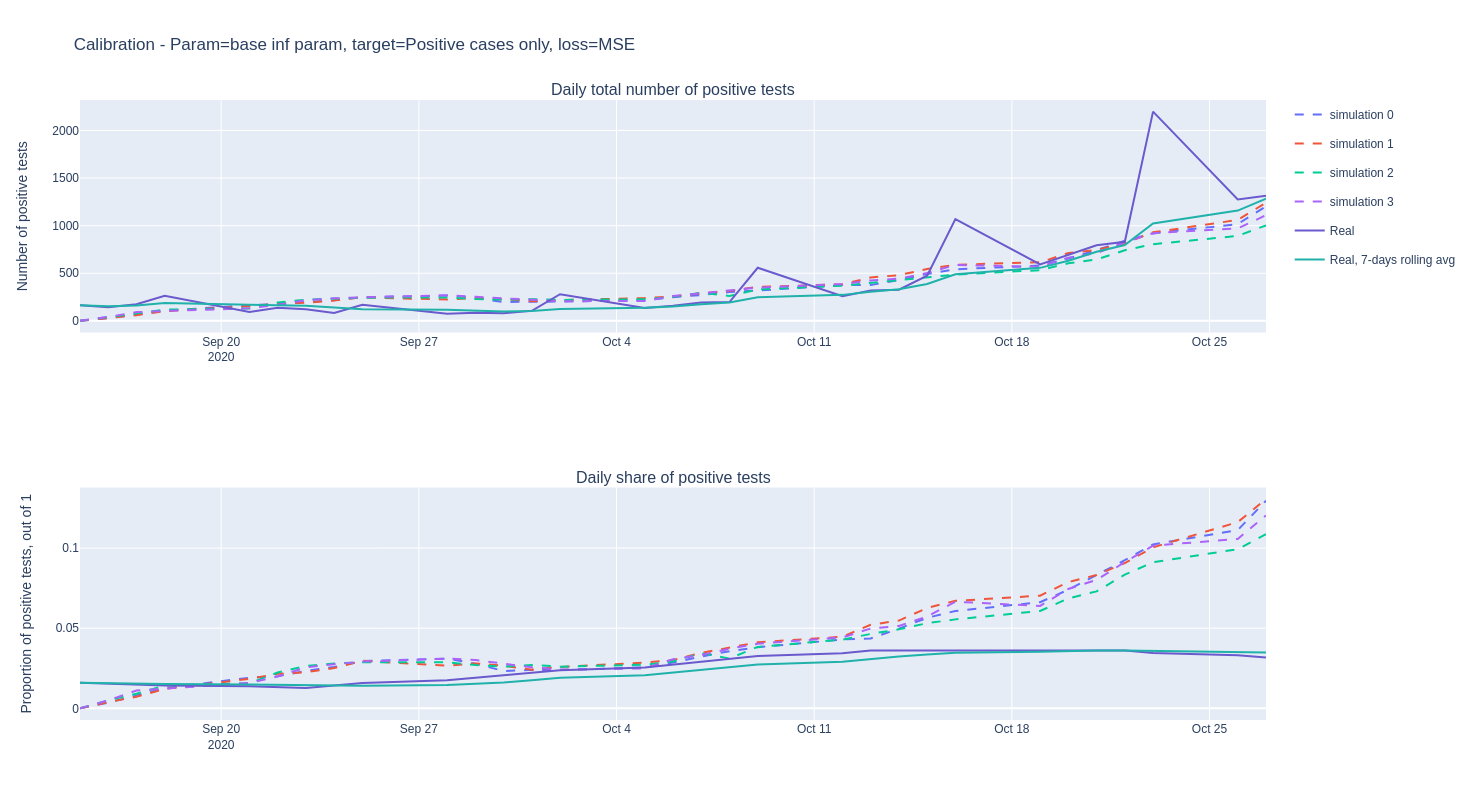

In [27]:
show_model_output(parallel_abm,
                  "Calibration - Param=base inf param, target=Positive cases only, loss=MSE",
                  "figures/abm/calibration/one_param/inf_para_target-pt_loss-mse.png")

### With Max distance

In [ ]:
single_param_opt = minimize_scalar(single_param_model_loss, bounds=[0, 1], method='bounded', args=('max'))
print(single_param_opt)

In [ ]:
show_model_output(parallel_abm,
                  "Calibration - Param=base inf param, target=Positive cases, loss=Max dist",
                  "figures/abm/calibration/one_param/inf_para_target-pt_loss-max.png")

# Inf + Inf test proba calibration
In this section, we'll try to optimize the ```inf_fraction_param``` and ```inf_test_proba``` parameters.

In [23]:
base_params = {
    'recovery_mean_time': 8.0,
    'recovery_std_time': 2.0,
    'soceco_attributes': ['age'],
    'soceco_params': np.array([0]),
    'inf_fraction_param': 0.01, # Value found in the previous section using MAE
    'test_attributes': ['age'],
    'test_params': np.array([0]),
    'base_test_proba': 0.0,
    'inf_test_proba': 0.2,
    'apply_activity_reduction': False
}
parallel_abm = ParallelABM(base_params, activity_data, n_models=4)

Loading the population dataset in the master..
Done
Computing population characteristics in the master...
Done
Assembling models 
Done


## Optimizing the positive tests only
Here we'll calibrate the two parameters to **only optimize the positive tests curve**: we won't be evaluating the quality of the simulation regarding the share of positive tests. Therefore, we can keep using the same loss functions as in the previous section.

In [24]:
def positive_tests_loss(parallel_abm, loss='mse'):
    """
    Computes the loss as the difference between the real number of positive
    tests over time, and the trajectory predicted by the simulation.
    """
    parallel_abm.force_simulation_start(forced_daily_infections)
    # Relaunches a simulation with the new param
    parallel_abm.run_simulations(simulation_days)
    # Retrieves the daily positive tests across all parallel simulations
    results = parallel_abm.get_results_dataframe(timestep='daily')
    # Computes the mean positive tests for every week
    model_mean = np.array(results.groupby('day')['positive tests'].mean())
    # Computes the loss
    if loss == 'mae':
        return mae_loss(model_mean)
    elif loss == 'mse':
        return mse_loss(model_mean)
    elif loss == 'max':
        return max((max_loss(results.query(f'simulation == {s}')['positive tests'])
                                     for s in range(parallel_abm.n_models)))
    else:
        raise ValueError(f'Loss {loss} not understood')

In [25]:
def two_params_pt_only_loss(params, loss='mse'):
    base_inf_proba, inf_test_proba = params[0], params[1]
    # Modifies the param in the ABM object and resets it
    parallel_abm.set_param('inf_fraction_param', base_inf_proba)
    parallel_abm.set_param('inf_test_proba', inf_test_proba)
    return positive_tests_loss(parallel_abm, loss)

### Loss by grid search
In this section, we'll compute the loss (MSE, positive tests only) for a grid of values for the two parameters. 

In [26]:
base_params = {
    'recovery_mean_time': 8.0,
    'recovery_std_time': 2.0,
    'soceco_attributes': ['age'],
    'soceco_params': np.array([0]),
    'inf_fraction_param': 0.01, # To calibrate
    'test_attributes': ['age'],
    'test_params': np.array([0]),
    'base_test_proba': 0.0,
    'inf_test_proba': 0.2, # To calibrate
    'apply_activity_reduction': False
}
parallel_abm = ParallelABM(base_params, activity_data, n_models=8)

Loading the population dataset in the master..
Done
Computing population characteristics in the master...
Done
Assembling models 
Done


In [27]:
inf_frac_values = np.linspace(0.01, 0.02, num=8)
inf_test_proba_values = np.linspace(0.05, 0.5, num=8)

In [ ]:
result_dfs = []
for inf_frac_val in inf_frac_values:
    print(f"Testing value {inf_frac_val} for the inf frac param")
    parallel_abm.set_param('inf_fraction_param', inf_frac_val)
    parallel_abm.set_varying_param('inf_test_proba', inf_test_proba_values)
    # Run the simulations and get the results dataframe
    parallel_abm.force_simulation_start(forced_daily_infections)
    parallel_abm.run_simulations(simulation_days)
    result_dfs.append(parallel_abm.get_results_dataframe(timestep='daily'))

In [29]:
losses = []
for df in result_dfs:
    losses.append([])
    for j, _ in enumerate(inf_test_proba_values):
        sim_output = df.query(f'simulation == {j}')['positive tests']
        losses[-1].append(mse_loss(sim_output))

In [30]:
print(np.array(losses).astype(int))

[[19 18 19 20 20 18 19 19]
 [16 16 14 16 16 14 16 16]
 [11 13 13 13 13 13 11 15]
 [13 12 13 14 14 11 13 13]
 [11 12 15 15 15 12 11 11]
 [18 16 19 16 16 16 18 15]
 [21 25 29 26 26 27 21 15]
 [34 45 49 45 45 40 34 29]]


# Optimizing the positive tests and share of positive tests
In the following section, we'll try to calibrate the parameters to best approximate both the curves of positive tests and share of positive tests. Naturally, those two measures are not direclty comparable, and need to be rescaled.  
In order to calibrate those two curves, we need to include at least the following three parameters: ```inf_fraction_param``` (force of infection), ```base_test_proba``` (probability for a non-infected agent to get tested at the end of each day), ```inf_test_proba``` (probability for an Infectious agent to get tested at the end of the day).

## Loss function

In [ ]:
def two_curves_loss(model_positive_tests, model_positive_share):
    """
    Computes the loss based on both the predicted positive tests, but
    also the share of positive tests.
    - model_positive_tests: 1D array, daily number of positive tests as
        predicted by the model;
    - model_positive_share: 1D array, daily share of positive tests, as
        predicted by the model;
    """
    # Rescales the positive tests curves to be between 0 and 1, like the
    # share of positive tests
    model_pred = (model_positive_tests - np.mean(target_cases)) / np.std(target_cases)
    cases = normalize(target_cases)